# Manipulating Time-series

Time-series are a key element when assessing solar resource data. In this section, we present several examples to learn how to deal with different formats in the data and few common tasks to prepare our time-series for later analysis, such as down and up-sampling data when we need different temporal resolution than that initially available or interpolating missing values in the data. 

The dataset used in the examples of this section is a customized dataset using solar radiation measurements from the Measurement and Instrumentation Data Center (MIDC) of the U.S. National Renewable Energy Laboratory (NREL). The station selected is located at the University of Nevada - Las Vegas (UNLV) and the data used are 1-minute GHI, DHI and DNI measurements for the year 2020 (Andreas and Stoffel, 2006).

In this section, we cover: <br>
- [1 Time-series handling](#timeseries_handling) <br>
- [2 Down and up-sampling time-series data](#timeseries_downup_sampling) <br>
- [3 Interpolating time-series data](#timeseries_interpolation) <br>
- [4 Visualizating time-series data](#timeseries_visualization)


***
<div style="text-align: right"> <i>Content by Javier Lopez Lorente</i> </div>

## 1 Time-series handling <a id='timeseries_handling'></a>
Datasets often come in different formats depending on the source. Those formats sometimes cannot be used straightaway to build a time-series and may require additional processing steps before building the time-series. For example:  <br>
- **What if date and time are in different columns?** <br> 
- **What if the year, month, day and time are in separate columns?** <br>
- **How to the define the timestamp format for a particular dataset?** <br>
- **How to deal with timestamp issues, local vs. universal (UTC) time?**

This subsection presents several examples to deal with different formats in which time-series data could come and shows how to build a time-series or *datetime series*, as known in Python, for later analysis. The processing steps to build time-series are based on [pandas library](https://pandas.pydata.org/).

Let's get started!

In [1]:
# Importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib

### 1.1 Build our customized dataset
In order to build the customized dataset for this section, we make use of the I/O tools of the Python library *pvlib* to retrieve the data from the UNLV station in the MIDC. Data from other stations from the MIDC can be also retrieved using this method by adapting the station ID in the query. The different station IDs are available in the [MIDC raw data page](https://midcdmz.nrel.gov/apps/data_api_doc.pl?_idtextlist).

In [2]:
# Dictionary to rename certain variables from the raw data
var_map = {'Global Horiz [W/m^2]': 'ghi',
           'Direct Normal [W/m^2]':'dni',
           'Diffuse Horiz (calc) [W/m^2]':'dhi',
           'Year':'year'}

# Retrieving the raw data from the station 
df_ref = pvlib.iotools.read_midc_raw_data_from_nrel('UNLV',                     # Station id
                                                    pd.Timestamp('20200101'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20201231'),   # End date  YYYYMMDD
                                                    variable_map=var_map)       # Variable Map
# Let's have a look to the first 2 rows of the dataset
df_ref.head(2)

,Unnamed: 0,year,DOY,PST,dni,ghi,Global UVA [W/m^2],Global UVE [W/m^2],Global UVE [Index],Dry Bulb Temp [deg C],...,Avg Wind Direction @ 30ft [deg from N],Peak Wind Speed @ 30ft [m/s],UVSAET Temp [deg C],Logger Temp [deg C],Logger Battery [VDC],Wind Chill Temp [deg C],dhi,Zenith Angle [degrees],Azimuth Angle [degrees],Airmass
2020-01-01 00:00:00-08:00,0,2020,1,0,-1.67051,-2.53035,-0.005,0.0,0.002,6.004,...,17.67,0.098,24.9,22.25,13.28,6.004,0.0,166.494,16.4003,-7999.0
2020-01-01 00:01:00-08:00,0,2020,1,1,-1.64962,-2.53035,-0.007,0.0,0.003,6.210,...,8.79,1.176,24.9,22.26,13.28,6.210,0.0,166.435,17.3510,-7999.0


In [3]:
# Let's have a look to the last 2 rows of the dataset
df_ref.tail(2)

,Unnamed: 0,year,DOY,PST,dni,ghi,Global UVA [W/m^2],Global UVE [W/m^2],Global UVE [Index],Dry Bulb Temp [deg C],...,Avg Wind Direction @ 30ft [deg from N],Peak Wind Speed @ 30ft [m/s],UVSAET Temp [deg C],Logger Temp [deg C],Logger Battery [VDC],Wind Chill Temp [deg C],dhi,Zenith Angle [degrees],Azimuth Angle [degrees],Airmass
2020-12-31 23:58:00-08:00,0,2020,366,2358,0.000000,-3.09366,-0.016,0.0,0.003,10.45,...,4.834,7.546,24.75,18.97,13.34,8.06,0.0,166.558,14.0772,-7999.0
2020-12-31 23:59:00-08:00,0,2020,366,2359,0.473466,-3.09367,-0.015,0.0,0.003,10.46,...,7.997,6.664,24.81,18.97,13.35,8.24,0.0,166.507,15.0409,-7999.0


The dataset is 1-minute resolution data with 21 variables related to meteorological and other relevant data: ambient temperature, wind speed, wind direction, global horizontal irradiance (GHI), direct normal irradiance (DNI), diffuse horizontal irradiance (DHI), zenith and azimuth angles, airmass, among other. 

For the examples in this section we will use GHI, DNI and DHI measurements and time-related data.

In [4]:
# Slice desired variables out of the 21 variables provided in the raw data. 
df_ref = df_ref[['ghi', 'dni', 'dhi', 'year']]

# Add multiple temporal data to the dataset
df_ref['month'] = df_ref.index.month
df_ref['day'] = df_ref.index.day
df_ref['hour'] = df_ref.index.hour
df_ref['minute'] = df_ref.index.minute
df_ref['date'] = df_ref.index.strftime('%Y-%m-%d')
df_ref['time'] = df_ref.index.strftime('%H:%M:%S')
df_ref['timestamp'] = df_ref.index.strftime('%Y-%m-%d %H:%M:%S%z')

# Epoch format
df_ref['epoch'] = df_ref.index.astype('int64')//1e9

# Reset the Index of the DataFrame
df_ref = df_ref.reset_index(drop=True)

# Let's have a look to the resulting columns of the dataset
df_ref.columns

Index(['ghi', 'dni', 'dhi', 'year', 'month', 'day', 'hour', 'minute', 'date',
       'time', 'timestamp', 'epoch'],
      dtype='object')

Let's visualize the first rows of the **customized reference dataframe:**

In [5]:
# First 3 rows in the dataframe
df_ref.head(3)

,ghi,dni,dhi,year,month,day,hour,minute,date,time,timestamp,epoch
0,-2.53035,-1.670510,0.0,2020,1,1,0,0,2020-01-01,00:00:00,2020-01-01 00:00:00-0800,1577865600
1,-2.53035,-1.649620,0.0,2020,1,1,0,1,2020-01-01,00:01:00,2020-01-01 00:01:00-0800,1577865660
2,-2.53035,-0.856135,0.0,2020,1,1,0,2,2020-01-01,00:02:00,2020-01-01 00:02:00-0800,1577865720


Now that we have our customized reference dataset of 1-minute irradiance measurements for 2020 and temporal data, we can start building the timeseries in different ways.

### 1.2 Time-series when timestamps are available:

When timestamps are available, the most straightforward way to build the DataFrame with a datetime index is to convert the column with the timestamp into datetime format and set it as index.

Let's see how!

In [6]:
# A new dataframe copy of the reference dataset
df = df_ref.copy()
# Convert the timestamp string into datetime format 
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S%z')
# Set timestamp column as index
df = df.set_index(df['timestamp'])
# See the first 3 rows of the DataFrame with Datetime Index
df.head(3)

,ghi,dni,dhi,year,month,day,hour,minute,date,time,timestamp,epoch
timestamp,,,,,,,,,,,,
2020-01-01 00:00:00-08:00,-2.53035,-1.670510,0.0,2020,1,1,0,0,2020-01-01,00:00:00,2020-01-01 00:00:00-08:00,1577865600
2020-01-01 00:01:00-08:00,-2.53035,-1.649620,0.0,2020,1,1,0,1,2020-01-01,00:01:00,2020-01-01 00:01:00-08:00,1577865660
2020-01-01 00:02:00-08:00,-2.53035,-0.856135,0.0,2020,1,1,0,2,2020-01-01,00:02:00,2020-01-01 00:02:00-08:00,1577865720


The format of the timestamp is specified in the argument 'format' as a string and can be adapted to any case. The available options in Python can be checked in this [link](https://strftime.org/). 

Universal Time Coordinated (UTC) is usually the timestamp provided for many solar radiation data networks and platforms like the BSRN, PVGIS, etc. However, data can be also reported in local time like in our example. Timestamps can be converted to other timezones with the funcion *tz_convert*, which can be useful when dealing with data from different databases and locations worldwide:

In [7]:
# Add UTC timestamp from the local time (Pacific Summer Time)
df['timestamp_utc'] = df.index.tz_convert('UTC')
# See the first 3 rows 
df.head(3)

,ghi,dni,dhi,year,month,day,hour,minute,date,time,timestamp,epoch,timestamp_utc
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00-08:00,-2.53035,-1.670510,0.0,2020,1,1,0,0,2020-01-01,00:00:00,2020-01-01 00:00:00-08:00,1577865600,2020-01-01 08:00:00+00:00
2020-01-01 00:01:00-08:00,-2.53035,-1.649620,0.0,2020,1,1,0,1,2020-01-01,00:01:00,2020-01-01 00:01:00-08:00,1577865660,2020-01-01 08:01:00+00:00
2020-01-01 00:02:00-08:00,-2.53035,-0.856135,0.0,2020,1,1,0,2,2020-01-01,00:02:00,2020-01-01 00:02:00-08:00,1577865720,2020-01-01 08:02:00+00:00


The valid timezone strings for other timezones can be found in this [link](https://pvlib-python.readthedocs.io/en/stable/timetimezones.html). When the timezone is not provided as part of the timestamp, the function *tz_localize* can be used to localize the values in a timezone-naive series. *tz_localize* will be used in the next example.

### 1.3 Time-series when date and time are available:

When date and time are available in separate columns, a timestamp can be created in a new column and the new column can then be set as index and localized. Let's have a look how to do that:


In [8]:
# A new dataframe copy of the reference dataset
df = df_ref.copy()
# New column with the date and time 
df['datetime'] = df['date'] + 'T' + df['time']
# Convert the new column into datetime format 
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S')
# Set the column 'datetime' as index and localize it to its timezone
df = df.set_index(df['datetime']).tz_localize('Etc/GMT+8')
# See the first 3 rows 
df.head(3)

,ghi,dni,dhi,year,month,day,hour,minute,date,time,timestamp,epoch,datetime
datetime,,,,,,,,,,,,,
2020-01-01 00:00:00-08:00,-2.53035,-1.670510,0.0,2020,1,1,0,0,2020-01-01,00:00:00,2020-01-01 00:00:00-0800,1577865600,2020-01-01 00:00:00
2020-01-01 00:01:00-08:00,-2.53035,-1.649620,0.0,2020,1,1,0,1,2020-01-01,00:01:00,2020-01-01 00:01:00-0800,1577865660,2020-01-01 00:01:00
2020-01-01 00:02:00-08:00,-2.53035,-0.856135,0.0,2020,1,1,0,2,2020-01-01,00:02:00,2020-01-01 00:02:00-0800,1577865720,2020-01-01 00:02:00


### 1.4 Time-series when the time data is split in multiple columns:

If time-related data are split across multiple columns, a timestamp can be created in a new column similarly than in the previous case. Let's imagine our dataset would have the year, month, day, hour, and minute in separate columns. In that case, we could build our time-series as follows:

In [9]:
# A new dataframe copy of the reference dataset
df = df_ref.copy()
# Let's reduce the code lines and define the new string within the 'to_datetime' function
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']], 
                                format = '%Y-%m-%d%H:%M')
# Set the column 'datetime' as index
df = df.set_index(df['datetime']) 
# Localize the datetime series
df.index = df.index.tz_localize('Etc/GMT+8') 
# See the first 3 rows 
df.head(3)

,ghi,dni,dhi,year,month,day,hour,minute,date,time,timestamp,epoch,datetime
datetime,,,,,,,,,,,,,
2020-01-01 00:00:00-08:00,-2.53035,-1.670510,0.0,2020,1,1,0,0,2020-01-01,00:00:00,2020-01-01 00:00:00-0800,1577865600,2020-01-01 00:00:00
2020-01-01 00:01:00-08:00,-2.53035,-1.649620,0.0,2020,1,1,0,1,2020-01-01,00:01:00,2020-01-01 00:01:00-0800,1577865660,2020-01-01 00:01:00
2020-01-01 00:02:00-08:00,-2.53035,-0.856135,0.0,2020,1,1,0,2,2020-01-01,00:02:00,2020-01-01 00:02:00-0800,1577865720,2020-01-01 00:02:00


### 1.5 Time-series when the timestamp is given as epoch (Unix Time)

If the dataset has epoch timestamps, note that the data will have UTC time. However, it can be converted to any timezone using the function *tz_convert*. If there are epoch timestamps, a datetime series can be formed as follows:

In [10]:
# A new dataframe copy of the reference dataset
df = df_ref.copy()
# Convert epoch timestamps to datetime format and localize
df['datetime'] = pd.to_datetime(df['epoch'], unit='s', utc=True)
# Set datetime as index and convert UTC time to local time
df = df.set_index(df['datetime']).tz_convert('Etc/GMT+8')
# See the results
df.head(3)

,ghi,dni,dhi,year,month,day,hour,minute,date,time,timestamp,epoch,datetime
datetime,,,,,,,,,,,,,
2020-01-01 00:00:00-08:00,-2.53035,-1.670510,0.0,2020,1,1,0,0,2020-01-01,00:00:00,2020-01-01 00:00:00-0800,1577865600,2020-01-01 08:00:00+00:00
2020-01-01 00:01:00-08:00,-2.53035,-1.649620,0.0,2020,1,1,0,1,2020-01-01,00:01:00,2020-01-01 00:01:00-0800,1577865660,2020-01-01 08:01:00+00:00
2020-01-01 00:02:00-08:00,-2.53035,-0.856135,0.0,2020,1,1,0,2,2020-01-01,00:02:00,2020-01-01 00:02:00-0800,1577865720,2020-01-01 08:02:00+00:00


We have seen how the same DataFrame with *datetimeindex* can be obtained in multiple ways depending on the format of time data provided.

***

## 2 Down and up-sampling time-series data<a id='timeseries_downup_sampling'></a>

When assessing solar resource, you may need a different time-resolution than your data for a particular part of the analysis. In those cases, it is possible to **down-sample and up-sample the data at different temporal resolutions** using two different methods within [pandas library](https://pandas.pydata.org/) called *resample* and *asfreq*. Depending on your needs, you will opt for one or the other. Regardless of the method, both of them require a DataFrame with *datetimeindex* either time-aware (localized) or time-naive (not localized). 

###  2.1 Method 'asfreq' vs. 'resample'
Let's first create a new DataFrame with only the columns with solar data and see the differences between both methods with examples.

In [11]:
# New DataFrame with 1-minute data and solar data
df_1min = df[['ghi', 'dhi', 'dni']]
# See our new DataFrame
df_1min.head(3)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.53035,0.0,-1.670510
2020-01-01 00:01:00-08:00,-2.53035,0.0,-1.649620
2020-01-01 00:02:00-08:00,-2.53035,0.0,-0.856135


Let's try to obtain a DataFrame down-sampled with the maximum monthly data with both methods and see the differences. With *asfreq*, it would be the following:

In [12]:
df_1min.asfreq("1M").max()

ghi   -2.529330
dhi    0.000000
dni   -0.834868
dtype: float64

With *resample* the result would be:

In [13]:
df_1min.resample("1M").max()

,ghi,dhi,dni
datetime,,,
2020-01-31 00:00:00-08:00,802.383,386.083,972.789
2020-02-29 00:00:00-08:00,956.928,582.715,1024.650
2020-03-31 00:00:00-08:00,1237.910,632.961,1011.700
2020-04-30 00:00:00-08:00,1370.180,705.203,999.360
2020-05-31 00:00:00-08:00,1253.240,590.468,983.210
2020-06-30 00:00:00-08:00,1340.240,943.659,999.233
2020-07-31 00:00:00-08:00,1260.490,1056.520,1015.320
2020-08-31 00:00:00-08:00,1114.410,659.908,1010.130
2020-09-30 00:00:00-08:00,1081.750,670.886,959.591


It is obvious that the outputs are not the same and that is because the methods work differently. *asfreq* takes the value at the simultaneous stamps given by the frequency argument. See below:

In [14]:
df_1min.asfreq("1M")

,ghi,dhi,dni
datetime,,,
2020-01-31 00:00:00-08:00,-3.65348,0.0,-1.669830
2020-02-29 00:00:00-08:00,-3.09137,0.0,-1.669820
2020-03-31 00:00:00-08:00,-2.52933,0.0,-0.834917
2020-04-30 00:00:00-08:00,-3.61963,0.0,-1.669340
2020-05-31 00:00:00-08:00,-3.22207,0.0,-1.669590
2020-06-30 00:00:00-08:00,-3.65326,0.0,-0.834868
2020-07-31 00:00:00-08:00,-4.21426,0.0,-1.857120
2020-08-31 00:00:00-08:00,-5.14251,0.0,-1.620990
2020-09-30 00:00:00-08:00,-4.21555,0.0,-1.690710


Then *.max()* has returned the maximum of each of the columns. 

In contrast, *resample* does return the maximum value within the period of time at the specified frequency. *resample* method requires a mathematical operation to perform in the resampled data (the maximum value in our case). Otherwise, it would return a *DatetimeIndexResampler* object without showing any data. See below:

In [15]:
df_1min.resample("1M")

The *resample* method accepts multiple **mathematical and statistical operations**. For example: maximum (max), minimum (min), arithmetic mean (mean), standard deviation (std), median (median), mode (mode), addition (sum), among others. 

Both methods allow for multiple **frequencies options**, the available frequency tags within Python can be found [here](https://stackoverflow.com/questions/35339139/where-is-the-documentation-on-pandas-freq-tags).

### 2.2 Down-sampling the data in a time-series

Down-sampling permits turning more frequent values into less frequent. In the context of solar resource and considering our 1-minute resolution dataset, down-sampling can be used for:
- Producing a timeseries of hourly/daily average irradiance.
- Producing a timeseries of maximum daily irradiance.
- Estimating the hourly/daily/monthly sums of irradiation.
- And many more!

Let's implement some of these listed examples!

#### Producing hourly average irradiance from minutely observations

In [16]:
# Resampling to hourly mean values
df_hourly = df_1min.resample("1H").mean()
# Showing the shape of the new DataFrame
df_hourly.shape # returns Rows, Columns

(8784, 3)

There are 8760 hours in a year. Yet, we can have a look to the first few rows of the DataFrame:

In [17]:
df_hourly.head(12)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.000000,-0.764837
2020-01-01 01:00:00-08:00,-2.508561,0.000000,-0.631080
2020-01-01 02:00:00-08:00,-1.943371,0.000000,-0.374704
2020-01-01 03:00:00-08:00,-2.023108,0.000000,-0.379228
2020-01-01 04:00:00-08:00,-1.683542,0.000000,-0.013457
2020-01-01 05:00:00-08:00,-1.891827,0.000000,-0.006960
2020-01-01 06:00:00-08:00,0.116990,0.351740,1.146154
2020-01-01 07:00:00-08:00,42.787289,42.289485,3.388552
2020-01-01 08:00:00-08:00,128.938495,114.490610,50.297509


A time-series with the maximum irradiance would be similar replacing *'mean()'* with *'max()'*.

#### Producing time-series of monthly total GHI, DHI, DNI irradiation from minutely observations

In [18]:
# Resampling to monthly aggregated values
monthly_energy = df_1min[['ghi', 'dhi', 'dni']].resample("1M").sum()*(1/60)
# See the results expressed in kWh·sqm
monthly_energy/1000

,ghi,dhi,dni
datetime,,,
2020-01-31 00:00:00-08:00,100.817440,29.251020,175.754908
2020-02-29 00:00:00-08:00,129.220507,30.514029,206.374110
2020-03-31 00:00:00-08:00,164.224723,59.140048,179.448458
2020-04-30 00:00:00-08:00,200.459859,59.307923,217.186189
2020-05-31 00:00:00-08:00,255.336215,54.922454,294.929842
2020-06-30 00:00:00-08:00,254.262295,62.085767,277.856782
2020-07-31 00:00:00-08:00,257.105784,48.821531,305.900237
2020-08-31 00:00:00-08:00,223.419662,56.213721,251.208590
2020-09-30 00:00:00-08:00,181.248566,58.956766,199.959672


It could be done in similar way for other resolutions (e.g. daily or annual irradiation).

### 2.3 Up-sampling the data in a time-series

Up-sampling permits obtaining more frequent values from less frequent. For solar data, depending on the application up to sub-minutely data could be required and up-sampling is a technique that provides a manner to increase the temporal resolution to adapt it to our needs. For example, turning an hourly time-series into a half-hourly. Let's see an example using both *resample* and *asfreq*.

#### Producing half-hourly irradiance series from hourly observations
Using the DataFrame *df_hourly* created previously, it can be up-sample as follows:

In [19]:
# Using 'resample' method:
df_hourly.resample("30Min").mean().head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 00:30:00-08:00,NaN,NaN,NaN
2020-01-01 01:00:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:30:00-08:00,NaN,NaN,NaN
2020-01-01 02:00:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:30:00-08:00,NaN,NaN,NaN
2020-01-01 03:00:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:30:00-08:00,NaN,NaN,NaN
2020-01-01 04:00:00-08:00,-1.683542,0.0,-0.013457


In [20]:
# Using 'asfreq' method:
df_hourly.asfreq("30Min").head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 00:30:00-08:00,NaN,NaN,NaN
2020-01-01 01:00:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:30:00-08:00,NaN,NaN,NaN
2020-01-01 02:00:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:30:00-08:00,NaN,NaN,NaN
2020-01-01 03:00:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:30:00-08:00,NaN,NaN,NaN
2020-01-01 04:00:00-08:00,-1.683542,0.0,-0.013457


Contrary to the case of down-sampling, both *asfreq* and *resample* provide similar results when up-sampling. However, *asfreq* provides additional functionalities to treat the new timestamps without data, i.e. NaN values.

By passing the argument *'method'* with the string *'backfill'* or *'bfill'* uses the next valid observation to fill the NaN value (back filling). If instead, the string *'pad'* or *'ffill'* is given, the method assigns the last valid observation forward to the next valid (forward filling). 

Let's see the same example adding this argument:

In [21]:
# Half-hourly up-sample with back filling function
df_hourly.asfreq("30Min", method='bfill').head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 00:30:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:00:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:30:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:00:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:30:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:00:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:30:00-08:00,-1.683542,0.0,-0.013457
2020-01-01 04:00:00-08:00,-1.683542,0.0,-0.013457


We see that the DataFrame now contains the next valid hourly value in the newly obtained half-hourly timestamps of the previous hour. It would take the previous valid hourly value if we used forward filling. For example:

In [22]:
# Half-hourly up-sample with forward-filling function
df_hourly.asfreq("30Min", method='ffill').head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 00:30:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 01:00:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:30:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 02:00:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:30:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 03:00:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:30:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 04:00:00-08:00,-1.683542,0.0,-0.013457


The forward filling option provides the same value for o'clock and half past timestamps within the same hour. In addition to these two ways to complete the NaN values, the method *asfreq* can replace the NaN values with a constant. See below:

In [23]:
# Half-hourly up-sample filling the new timestamps with a constant
df_hourly.asfreq("30Min", fill_value=0).head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 00:30:00-08:00,0.000000,0.0,0.000000
2020-01-01 01:00:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:30:00-08:00,0.000000,0.0,0.000000
2020-01-01 02:00:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:30:00-08:00,0.000000,0.0,0.000000
2020-01-01 03:00:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:30:00-08:00,0.000000,0.0,0.000000
2020-01-01 04:00:00-08:00,-1.683542,0.0,-0.013457


The use of the methods *asfreq* or *resample* will depend on your dataset and the analysis you aim to undertake.

***

## 3 Interpolating time-series data<a id='timeseries_interpolation'></a>

When up-sampling the data series, it can happen that back-filling, forward-filling and constant replacement does not necessarily work for your analysis/application. An alternative approach is interpolating the replacing the NaN values with an interpolated result. Interpolation in Pandas DataFrames with *DatetimeIndex* is done with the *interpolate* method.

The mathematical interpolation method in *interpolate* is defined with the argument called *'method'*. Pandas permits several interpolation methods, such as 'linear', 'cubic', 'quadratic', 'spline', 'polynomial' and others. All the interpolation options can be found in the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) of the *interpolate* method. 

Following the previous example, let's implement interpolation in the missing values of the half-hourly timestamps using 'linear', 'cubic' and 'polynomial' methods:

In [24]:
# Up-sample using the 'asfreq' method
df_30min = df_hourly.asfreq("30Min")
# Interpolate missing values (NaN) with linear interpolation
df_linear = df_30min.interpolate(method='linear')
# See the results:
df_linear.head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.0,-0.764837
2020-01-01 00:30:00-08:00,-2.542533,0.0,-0.697958
2020-01-01 01:00:00-08:00,-2.508561,0.0,-0.631080
2020-01-01 01:30:00-08:00,-2.225966,0.0,-0.502892
2020-01-01 02:00:00-08:00,-1.943371,0.0,-0.374704
2020-01-01 02:30:00-08:00,-1.983240,0.0,-0.376966
2020-01-01 03:00:00-08:00,-2.023108,0.0,-0.379228
2020-01-01 03:30:00-08:00,-1.853325,0.0,-0.196342
2020-01-01 04:00:00-08:00,-1.683542,0.0,-0.013457


Similarly, it can be implemented to other methods:

In [25]:
# Interpolate missing values (NaN) with cubic interpolation
df_cubic = df_30min.interpolate(method='cubic')
# See the results:
df_cubic.head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.000000,-0.764837
2020-01-01 00:30:00-08:00,-2.708668,0.015477,-0.754314
2020-01-01 01:00:00-08:00,-2.508561,0.000000,-0.631080
2020-01-01 01:30:00-08:00,-2.184142,-0.015477,-0.477191
2020-01-01 02:00:00-08:00,-1.943371,0.000000,-0.374704
2020-01-01 02:30:00-08:00,-1.929019,0.046430,-0.371559
2020-01-01 03:00:00-08:00,-2.023108,0.000000,-0.379228
2020-01-01 03:30:00-08:00,-2.027425,-0.170243,-0.284694
2020-01-01 04:00:00-08:00,-1.683542,0.000000,-0.013457


With polynomial interpolation, the degree or order of the polynomial function needs to be defined as an argument:

In [26]:
# Interpolate missing values (NaN) with polynomial interpolation
df_polynomial = df_30min.interpolate(method='polynomial', order=5)
# See the results:
df_polynomial.head(10)

,ghi,dhi,dni
datetime,,,
2020-01-01 00:00:00-08:00,-2.576505,0.000000,-0.764837
2020-01-01 00:30:00-08:00,-1.992626,0.512587,0.655667
2020-01-01 01:00:00-08:00,-2.508561,0.000000,-0.631080
2020-01-01 01:30:00-08:00,-2.485236,-0.214189,-1.068238
2020-01-01 02:00:00-08:00,-1.943371,0.000000,-0.374704
2020-01-01 02:30:00-08:00,-1.619687,0.201377,0.199990
2020-01-01 03:00:00-08:00,-2.023108,0.000000,-0.379228
2020-01-01 03:30:00-08:00,-2.535919,-0.346026,-1.263387
2020-01-01 04:00:00-08:00,-1.683542,0.000000,-0.013457


The interpolation of NaN values when up-sampling time-series data can help overcome the issues of using back or forward filling, specially if you aim to up-sample at higher frequencies than the example shown (e.g. 1-hour to 15-minute resolution series). The mathematical methods available for interpolation within Pandas are diverse and cover beyond the most common interpolation functions.

## 4 Visualizing time-series data<a id='timeseries_visualization'></a>

It is often useful to visualize the data to grasp insighs and observe trends about the data. This section shows few examples to visualize time-series data.

### 4.1 Plotting a time-series for a day of interest

Below there is an example to visualize a single day of interest. With DataFrames using *DatetimeIndex* it is easy to select a particular day and Pandas interacts with Matplotlib.Pyplot library to plot straight-away.

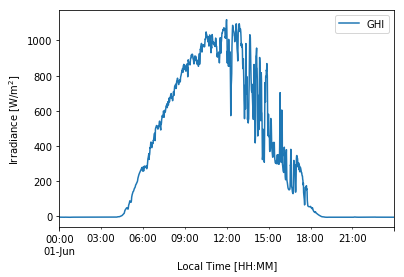

In [27]:
# Plotting GHI for a given day in the time-series
df_1min['2020-06-01']['ghi'].plot(label='GHI')
plt.ylabel('Irradiance [W/m$^2$]')
plt.xlabel('Local Time [HH:MM]')
plt.legend(loc='best')
plt.show() # Not needed in Jupyter Notebooks but usually required in other IDEs.

We can visualize the effect of using average (*resample*) vs. instantaneous (*asfreq*) measurements when down-sampling our data.

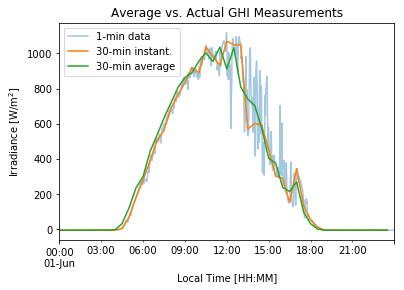

In [28]:
# Plotting GHI for a given day in the time-series
df_1min['2020-06-01']['ghi'].plot(label='1-min data', alpha=0.4) # Reference data
df_1min.asfreq('30Min')['2020-06-01']['ghi'].plot(label='30-min instant.') # Instantaneous 30-min values
df_1min.resample('30Min').mean()['2020-06-01']['ghi'].plot(label='30-min average') # Average 30-min values
plt.title('Average vs. Actual GHI Measurements') # title of the figure
plt.ylabel('Irradiance [W/m$^2$]') # y-axis label
plt.xlabel('Local Time [HH:MM]') # x-axis label
plt.legend(loc='upper left') # insert legend
plt.show() # Not needed in Jupyter Notebook but usually required in other IDEs.

### 4.2 Plotting a time-series for a few consecutive days of interest

Below there is an example to visualize a few consecutive days (e.g. 5 days) of interest. By using ['start date']:['end date'] it is possible to select time ranges easily with a DataFrame having a *DatetimeIndex*.

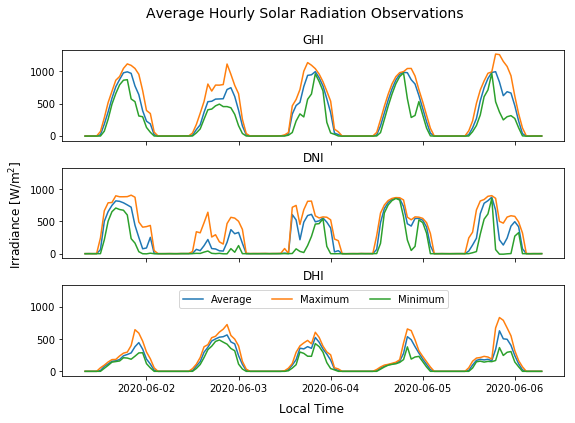

In [29]:
# Variables to plot
vars = ['ghi', 'dni', 'dhi'] 
# Create 3 subplots, with shared X and Y axis
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(9,6))
# Add title to the plot
fig.suptitle('Average Hourly Solar Radiation Observations', fontsize=14)

for i in range(3):
    axs[i].plot(df_1min.resample('1H').mean()['2020-06-01':'2020-06-05'][vars[i]], label='Average') # Average hourly
    axs[i].plot(df_1min.resample('1H').max()['2020-06-01':'2020-06-05'][vars[i]], label='Maximum') # Max. hourly
    axs[i].plot(df_1min.resample('1H').min()['2020-06-01':'2020-06-05'][vars[i]], label='Minimum') # Min. hourly
    axs[i].set_title(vars[i].upper()) # Title for each subplot
fig.subplots_adjust(hspace=0.3) # Adjust the white space between the subplots titles
fig.text(0.04, 0.5, 'Irradiance [W/m$^2$]', va='center', rotation='vertical', fontsize=12) # Common Y Axis
fig.text(0.51, 0.04, 'Local Time', ha='center', fontsize=12) # Common X Axis
plt.legend(loc='upper center', ncol=3) # Legend for the last subplot or 'axs[i].legend()' in the loop to a legend to each.
plt.show()

### 4.3 Plotting a time-series for a few non-consecutive days of interest

Below there is an example to visualize a few non-consecutive days of interest, which could be the case when we would like to observe several days scattered throughout the year a single plot. In order to do this, we need to select the day of interest from the DataFrame and then reset its *DatetimeIndex*. For example:

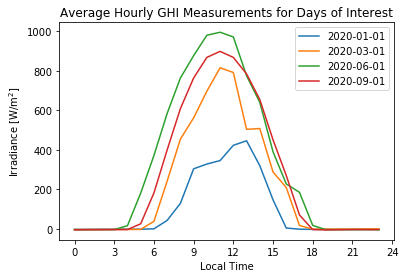

In [30]:
# List of days of interest
days = ['2020-01-01', '2020-03-01', '2020-06-01', '2020-09-01']
# Iterate over the days and plot each of them
for day in days: 
    df_day = df_1min.resample('1H').mean()[day]['ghi'].to_frame()  # average hourly of GHI for current day
    df_day = df_day.reset_index(drop=True) # reset its Index to numeric (i.e. 0,1,2,3...)
    plt.plot(df_day, label=day) # plot the current day
plt.title('Average Hourly GHI Measurements for Days of Interest') # title of the figure
plt.xticks(np.arange(0, 25, step=3), np.arange(0, 25, step=3)) # set labels positions and names
plt.ylabel('Irradiance [W/m$^2$]') # y-axis label
plt.xlabel('Local Time') # x-axis label
plt.legend(loc='best') # insert legend
plt.show()

### 4.4 Daily insolation throughout the year

With time-series data, the hourly/daily/monthly insolation (i.e. the sum of accumulated energy) can also be analysed throughout the year with time-series data. For example, below an example to visualize the daily insolation is shown:

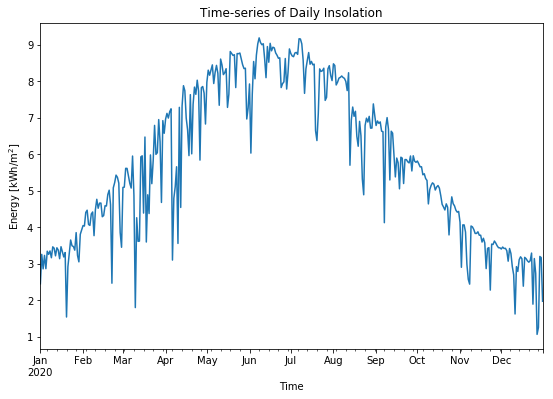

In [31]:
# Calculate the daily insolation expressed in kWh·sqm from GHI measurements
daily_energy = (df_1min['ghi'].resample("1D").sum()*(1/60))/1000 # selecting only GHI returns a Pandas Series

# Create time-series plot
daily_energy.plot(figsize=(9,6), legend=False) # plot timeseries 
plt.title('Time-series of Daily Insolation')  # add title
plt.ylabel('Energy [kWh/m$^2$]') # add Y-axis label
plt.xlabel('Time') # add X-axis label
plt.show()

Time-series data can also be visualized in other ways, for instance, as a heat map.

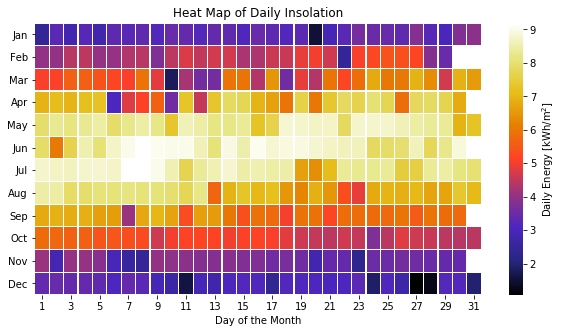

In [32]:
# Prepare the data for heat map of hourly insolation
energy_array = pd.DataFrame() # empty DataFrame for the results
for i in range(1,13): # iterate over months
    # select the data in the month and eliminate the datetimeindex
    df_month = daily_energy[daily_energy.index.month==i].reset_index(drop=True) 
    # rename the column with the number of the month
    df_month.columns = [str(i)]
    # Append results to the DataFrame
    energy_array = pd.concat([energy_array, df_month], axis=1)
# Transpose to have months in y-axis and days in x-axis
energy_array = energy_array.transpose()
# Rename the columns of the days 
energy_array.columns = np.arange(1, 32)

# Plot heat map of daily insolation
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', # month labels
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(10, 5))
ax = sns.heatmap(energy_array, cmap='CMRmap', linewidths=0.2, # plot heatmap with Seaborn (sns) library 
                xticklabels=2, annot=False,
                cbar_kws={'label': 'Daily Energy [kWh/m$^2$]'})
ax.set_title('Heat Map of Daily Insolation') # add title
ax.set_yticklabels(months,rotation=0) # add the months as tick-labels for the y-axis
ax.set_xticklabels(ax.get_xticklabels(),rotation=0) # add the days as tick-labels for the x-axis
ax.set_xlabel('Day of the Month')
plt.show()

***

## Section summary

This section has shown how to build and work with a time-series in Python with multiple examples: <br>
- We have seen how to prepare a DataFrame with *DatatimeIndex* to be used as a time-series when the timestamps are given in multiple formats in the temporal data and local/UTC time. <br>
- Changes in the temporal resolution of the data can be applied by down and up-sampling the data and the differences between 2 available methods (*asfreq* and *resample*) have been shown with examples and different sampling frequencies. <br> 
- The interpolation of missing data in time-series can be used to up-sample the resolution of the data and examples with some methods have been shown. <br>
- Finally, several ideas to visualize data have been presented. <br>

Overall, the possibilities with time-series of solar resource are many. The most useful and suitable analysis and visualizations will be determined by the application and scope of the study.

***

## References<a id='references'></a>

Andreas, A.; Stoffel, T.; (2006). University of Nevada (UNLV):
Las Vegas, Nevada (Data); NREL Report No. DA-5500-56509.
http://dx.doi.org/10.5439/1052548
